# load package

In [1]:
import torch
from torchSimple.models import TorchClassifier

# load dataset

使用的数据集为“长江流域水质等级数据”

In [2]:
import numpy as np
import pandas as pd
import os

X = np.loadtxt('/media/titan2/ed68ee25-5900-4420-b4c5-b77ca64f29e2/WZD/WR/lookback28_feture4_X.csv')
y = np.loadtxt('/media/titan2/ed68ee25-5900-4420-b4c5-b77ca64f29e2/WZD/WR/lookback28_feture4_y.csv')

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# change the shape to import the resnet18 model.
x_train = torch.tensor(x_train).view(-1, 1, 7, 28)
x_test = torch.tensor(x_test).view(-1, 1, 7, 28)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [3]:
x_train.size(), x_test.size()

(torch.Size([177128, 1, 7, 28]), torch.Size([44282, 1, 7, 28]))

# Rewrite the "TorchClassifier" class

这里修改的有四个函数，以及batch size，save folder，若需要更多可前往源码复制粘贴修改.

In [4]:
class ResNet18Classifier(TorchClassifier):
    def __init__(self):
        self.batch_size = 2048
        
        # 可修改保存路径
        self.save_folder = './resnet18_model_weights'
        if not os.path.exists(self.save_folder):
            os.makedirs(self.save_folder)
    
    def set_load_weights(self, path='model_weights_0.746.pt'):
        # 设置要加载的模型权重，如果没有, 则会自动跳过，无需设置为None.
        return os.path.join(self.save_folder, path)
    
    def set_criterion(self):
        return torch.nn.CrossEntropyLoss()
    
    def set_optimizer(self, model):
        return torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-8)
    
    def set_scheduler(self, optimizer):
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

# use the resnet18 model

使用 torchvision 自带的 resnet18 模型，调整输入输出层的参数. 

In [5]:
from torchvision import models
import torch.nn as nn

model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=6, bias=True)

使用 fit 训练模型，需要传 6 个参数.

In [6]:
resn_clf = ResNet18Classifier()
resn_clf.fit(x_train, y_train, x_test, y_test, model, epochs=5)

Let's use 2 GPUs!
--------------------
EPOCH:1/5


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Traning losses:0.5206788778305054; Accuary:0.826, Precision:0.679, Recall:0.611, F1:0.638
Testing losses:0.41185662150382996; Accuary:0.862, Precision:0.749, Recall:0.701, F1:0.721
Now best f1 score is: 0.721, save the weights parameters
--------------------
EPOCH:2/5


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Traning losses:0.3797527253627777; Accuary:0.87, Precision:0.78, Recall:0.698, F1:0.731
Testing losses:0.3842516541481018; Accuary:0.869, Precision:0.779, Recall:0.701, F1:0.731
Now best f1 score is: 0.731, save the weights parameters
--------------------
EPOCH:3/5


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Traning losses:0.3706817030906677; Accuary:0.872, Precision:0.786, Recall:0.703, F1:0.736
Testing losses:0.3774953782558441; Accuary:0.87, Precision:0.778, Recall:0.705, F1:0.736
Now best f1 score is: 0.736, save the weights parameters
--------------------
EPOCH:4/5


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Traning losses:0.3692777752876282; Accuary:0.873, Precision:0.788, Recall:0.705, F1:0.739
Testing losses:0.37761133909225464; Accuary:0.87, Precision:0.782, Recall:0.699, F1:0.732
--------------------
EPOCH:5/5


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Traning losses:0.36953040957450867; Accuary:0.873, Precision:0.788, Recall:0.705, F1:0.738
Testing losses:0.37760722637176514; Accuary:0.87, Precision:0.778, Recall:0.709, F1:0.738
Now best f1 score is: 0.738, save the weights parameters
Time consuming:73.63041400909424


使用 predict 预测结果，需调用 fit 产生的模型参数（保存在 "resnet18_model_weights"文件夹 里，通过“ls -l -R ./resnet18_model_weights/”查看）

In [7]:
! ls -l -R ./resnet18_model_weights/

./resnet18_model_weights/:
total 306104
-rw-rw-r-- 1 titan2 titan2 44783225 2月  18 16:34 entire_resnet18_model.pt
-rw-rw-r-- 1 titan2 titan2 44775929 2月  18 16:33 model_weights_0.683.pt
-rw-rw-r-- 1 titan2 titan2 44775929 2月  18 16:36 model_weights_0.721.pt
-rw-rw-r-- 1 titan2 titan2 44775929 2月  18 16:36 model_weights_0.731.pt
-rw-rw-r-- 1 titan2 titan2 44775929 2月  18 16:35 model_weights_0.735.pt
-rw-rw-r-- 1 titan2 titan2 44775929 2月  18 16:36 model_weights_0.736.pt
-rw-rw-r-- 1 titan2 titan2 44775929 2月  18 16:36 model_weights_0.738.pt


可以看到 fit 时候产生了上述多个文件，格式均为 model_weights_0.xxx.pt，其中0.xxx 为 f1 值，选择最高分数即可.

In [8]:
prediction = resn_clf.predict(x_test, model, load_weights='./resnet18_model_weights/model_weights_0.738.pt')

Let's use 2 GPUs!


  0%|          | 0/22 [00:00<?, ?it/s]

调用 class 自带的评估指标 estimate

In [9]:
acc, precision, recall, f1 = resn_clf.estimate(y_test=y_test.numpy(), y_pred=prediction)
print('acc:{}, precision:{}, recall:{}, f1:{}'.format(acc, precision, recall, f1))

acc:0.8702407298676663, precision:0.7779979232432871, recall:0.7085190272492895, f1:0.7379492783305438


# 调用 utils 绘制混淆矩阵

Normalized confusion matrix


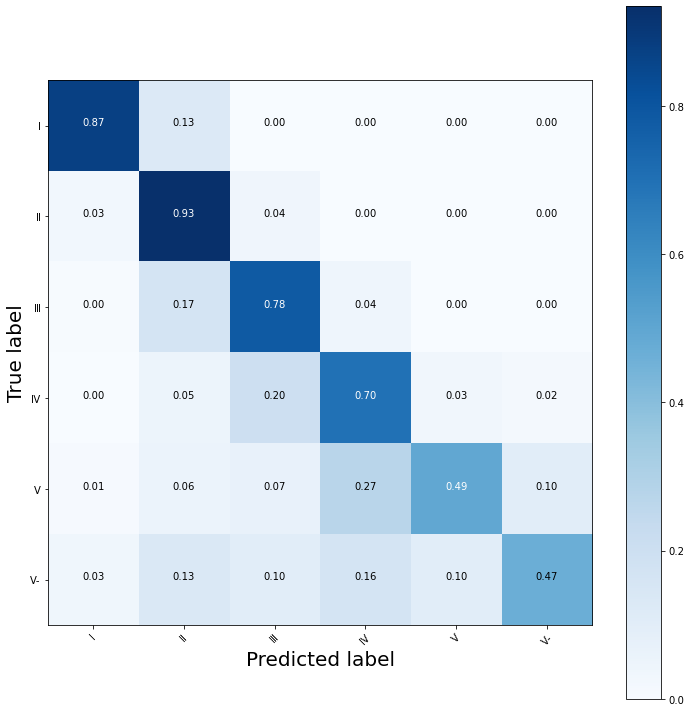

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from torchSimple.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.numpy(),
                              prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ', 'Ⅴ', 'Ⅴ-'],normalize=True,
                      title='./resnet18_model_confusion_matrix.png')
plt.show()

# 可考虑是否需要保存整个模型

目的是保存自己写的模型，这样后续可直接 load 整个模型及其最优 参数.

In [11]:
# Specify a path
PATH = "./resnet18_model_weights/entire_resnet18_model.pt"
# Save
torch.save(model, PATH)

In [12]:
# Load
model = torch.load(PATH)

查看模型是否加载成功

In [13]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  